In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import re
from datetime import datetime as dt
from tqdm import tqdm
import scipy.stats as ss
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import recall_score, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import PrecisionRecallCurve

%matplotlib inline

# Extract

In [28]:
key = '69d03443c6dda74d5729a2be5debd168'

In [29]:
# tmdb_api_url = 'https://api.themoviedb.org/3/'

# def get_genres(api_key=key):
#     api_key = f'api_key={api_key}'
#     tmdb_api_url = 'https://api.themoviedb.org/3/'
    
#     get_genres = 'genre/movie/list'
#     response = requests.get(tmdb_api_url + '?'.join([get_genres, api_key]))
#     genres = response.json()['genres']
    
#     genres_ls = [d['name'] for d in genres]
#     genres_ls.append('Foreign')
#     genres_ls = sorted(genres_ls)
#     n_genres = len(genres_ls)
    
#     return {'n_genres': n_genres, 'genres_ls': genres_ls}

# def get_details_reviews(api_key=key, goodness_thresh=80, **kwargs):
#     api_key = f'api_key={api_key}'
#     n_genres = kwargs['n_genres']
#     genres_ls = kwargs['genres_ls']
    
#     tmdb = pd.read_csv('data/tmdb_5000_movies.csv')

#     tmdb['goodness'] = tmdb['vote_average'] * tmdb['vote_count'] / tmdb['vote_count'].max()
#     # threshold -> 80th percentile (default)
#     threshold = np.around(np.percentile(tmdb['goodness'], goodness_thresh), 2)
#     # encoding 1 <-> goodness >= threshold
#     tmdb['goodness_enc'] = 0
#     tmdb.loc[tmdb['goodness'] >= threshold, 'goodness_enc'] = 1
    
#     cols_to_keep = ['id', 'title', 'status', 'release_date', 'budget', 'revenue',
#                     'original_language', 'runtime', 'popularity', 'goodness_enc']
#     # keeping only movies that have a positive vote_count
#     tmdb_clean = tmdb.loc[tmdb['vote_count'] > 0, cols_to_keep].dropna(axis=0).reset_index(drop=True)
    
#     reviews = pd.Series(name='reviews')
#     df_genres = pd.DataFrame(columns=genres_ls)
    
#     for i, movie_id in enumerate(tqdm(tmdb_clean['id'])):
#         get_reviews = f'movie/{movie_id}/reviews'
#         response_reviews = requests.get(tmdb_api_url + '?'.join([get_reviews, api_key]))
#         if response_reviews.status_code == 200:
#             reviews.loc[i] = [d['content'] for d in response_reviews.json()['results']]
#         else:
#             reviews.loc[i] = []

#         df_genres.loc[i] = np.zeros(n_genres, dtype=int)
#         movie_genres = re.findall(r'\"name\": \"([A-Za-z\s]+)\"', tmdb['genres'][i])
#         df_genres.loc[i, movie_genres] = 1
        
#     df = pd.concat([tmdb_clean, df_genres, reviews], axis=1).sort_values('id').reset_index(drop=True)

#     # turning dtype of release_date to datetime and extracting only the year
#     df['release_date'] = pd.to_datetime(df['release_date'], infer_datetime_format=True).dt.year
#     df = df.rename(columns={'release_date': 'release_year'})

#     # keeping only movies that have been released
#     df = df[df['status'] == 'Released'].reset_index(drop=True)
#     details = df.drop(['status', 'reviews', 'Foreign', 'TV Movie'], axis=1)
#     details.to_csv('data/details.csv', index=False)
    
#     reviews = df[['id', 'title', 'reviews', 'goodness_enc']]
#     reviews.to_csv('data/reviews.csv', index=False)

In [30]:
get_details_reviews()

100%|██████████| 4740/4740 [1:35:23<00:00,  1.21s/it]  


# Load and Clean

In [343]:
def clean_details(df):
    # binning low count languages (<10) in category called 'other'
    lang_counts = df['original_language'].value_counts()
    df.loc[df['original_language'].isin(lang_counts[lang_counts < 10].index), 'original_language'] = 'other'
    
    # dropping features that are irrelevant for prediction
    df.drop(['id', 'title'], axis=1, inplace=True)
    
    return df

# def clean_reviews(df):
#     return df

def get_data(csv_file, target='goodness_enc'):
    df = pd.read_csv(f'data/{csv_file}.csv')
    
    df_clean = clean_details(df)
    X = df_clean.drop(target, axis=1)
    X = pd.get_dummies(X, drop_first=True)
    y = df_clean[target]
    
    return {'X': X, 'y': y}

# Transform

In [344]:
def split_func(test_size=.2, **kwargs):
    X = kwargs['X']
    y = kwargs['y']
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=test_size,
                                                        stratify=y)
    
    return X_train, X_test, y_train, y_test

In [215]:
X_train, X_test, y_train, y_test = split_func(**get_data(csv_file='details'))

# Models

## Logistic Regression

In [294]:
logr_clf = LogisticRegression(max_iter=5000,
                              random_state=42,
                              n_jobs=-1)

logr_params = {'logr__penalty': ['l1', 'l2', 'elasticnet'],
               'logr__C': ss.uniform(0, 100),
               'logr__l1_ratio': ss.uniform(0, 1)}

## k Nearest Neighbors  (kNN)

In [295]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

knn_params = {'knn__n_neighbors': range(1,100,2),
              'knn__weights': ['uniform', 'distance']}

## Support Vector Machine (SVM)

In [296]:
svm_clf = SVC(max_iter=5000,
              random_state=42)

svm_params = {'svm__C': ss.uniform(0, 100),
              'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'svm__degree': [1, 2, 3],
              'svm__coef0': ss.uniform(0, 10)}

## Random Forest (RF)

In [297]:
rf_clf = RandomForestClassifier(n_jobs=-1,
                                random_state=42)

rf_params = {'rf__n_estimators': range(1,500),
             'rf__criterion': ['gini', 'entropy'],
             'rf__max_depth': [1, 2, 3, 4],
             'rf__max_features': range(1, X_train.shape[1]),
             'rf__max_samples': range(1, X_train.shape[0])}

## Light Gradient Boosting Machine (LGBM)

In [298]:
lgbm_clf = LGBMClassifier(max_iter=5000,
                          random_state=42,
                          n_jobs=-1)

lgbm_params = {'lgbm__boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
               'lgbm__max_depth': [1, 2, 3, 4],
               'lgbm__learning_rate': ss.uniform(0, 1),
               'lgbm__n_estimators': range(1,500),
               'lgbm__subsample': ss.uniform(0.001, 1),
               'lgbm__subsample_freq': range(1,101),
               'lgbm__colsample_bytree': ss.uniform(0.001, 1),
               'lgbm__reg_alpha': ss.uniform(0, 1),
               'lgbm__reg_lambda': ss.uniform(0, 1)}

## Extreme Gradient Boosting (XGBoost)

In [299]:
xgb_clf = XGBClassifier(max_iter=5000,
                        random_state=42)

xgb_params = {'xgb__max_depth': [1, 2, 3, 4],
              'xgb__learning_rate': ss.uniform(0, 1),
              'xgb__boster': ['gbtree', 'gblinear', 'dart'],
              'xgb__subsample': ss.uniform(0.001, 1),
              'xgb__colsample_bytree': ss.uniform(0.001, 1),
              'xgb__colsample_bylevel': ss.uniform(0.001, 1),
              'xgb__colsample_bynode': ss.uniform(0.001, 1),
              'xgb__reg_alpha': ss.uniform(0, 1),
              'xgb__reg_lambda': ss.uniform(0, 1),
              'xgb__num_parallel_tree': range(1,500)}

## Multilayer Perceptron (MLP)

In [300]:
mlp_clf = MLPClassifier(max_iter=5000,
                        early_stopping=True,
                        random_state=42)

mlp_params = {'mlp__hidden_layer_sizes': range(1,500),
              'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
              'mlp__solver': ['lbfgs', 'sgd', 'adam'],
              'mlp__alpha': ss.uniform(0, 1),
              'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
              'mlp__learning_rate_init': ss.uniform(0, 1),
              'mlp__momentum': ss.uniform(0, 1),
              'mlp__beta_1': ss.uniform(0, 0.999),
              'mlp__beta_2': ss.uniform(0, 0.999)}

## Pipeline

In [301]:
models = {'logr': [logr_clf, logr_params],
          'knn': [knn_clf, knn_params],
          'svm': [svm_clf, svm_params],
          'rf': [rf_clf, rf_params],
          'lgbm': [lgbm_clf, lgbm_params],
          'xgb': [xgb_clf, xgb_params],
          'mlp': [mlp_clf, mlp_params]}

In [281]:
best_estimators = {}
for m in tdm(models.keys()):
    print(m)
    pipeline = Pipeline([('scaler', StandardScaler()),
                         ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
                         (m, models[m][0])])

    rscv = RandomizedSearchCV(pipeline,
                              models[m][1],
                              scoring='recall',
                              n_jobs=-1,
                              cv=3,
                              n_iter=100,
                              verbose=True)

    rscv.fit(X_train, y_train)
    
    best_estimators[m] = rscv.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished
/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1499: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.1min finished


[LibSVM]

/home/jeffc/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   48.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 305 out of 305 | elapsed:    0.4s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/jeffc/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished


# Evaluation

## Recall Scores (threshold = 0.5)

In [329]:
recall_scores = {}
recall_scores['train recall'] = []
recall_scores['test recall'] = []
for m in best_estimators.keys():
    best = best_estimators[m]
    y_train_pred = best.predict(X_train)
    y_test_pred = best.predict(X_test)
    recall_scores['train recall'].append(round(100 * cross_val_score(best,
                                                               X_train,
                                                               y_train,
                                                               scoring='recall',
                                                               n_jobs=-1).mean(), 4))
    recall_scores['test recall'].append(round(100 * recall_score(y_test, y_test_pred), 4))

recall_scores_df = pd.DataFrame(recall_scores, index=list(best_estimators.keys()))
recall_scores_df




  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:02<00:08,  2.15s/it]


 40%|████      | 2/5 [00:05<00:07,  2.59s/it]


 60%|██████    | 3/5 [00:10<00:06,  3.29s/it][Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 305 out of 305 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 305 out of 305 | elapsed:    0.1s finished



 80%|████████  | 4/5 [00:12<00:02,  2.74s/it]


100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


,train recall,test recall
logr,78.6156,82.8125
knn,57.8881,57.2917
svm,78.6164,78.6458
rf,85.0055,84.3750
lgbm,90.3446,93.2292


## Learning Curves

KeyboardInterrupt: 

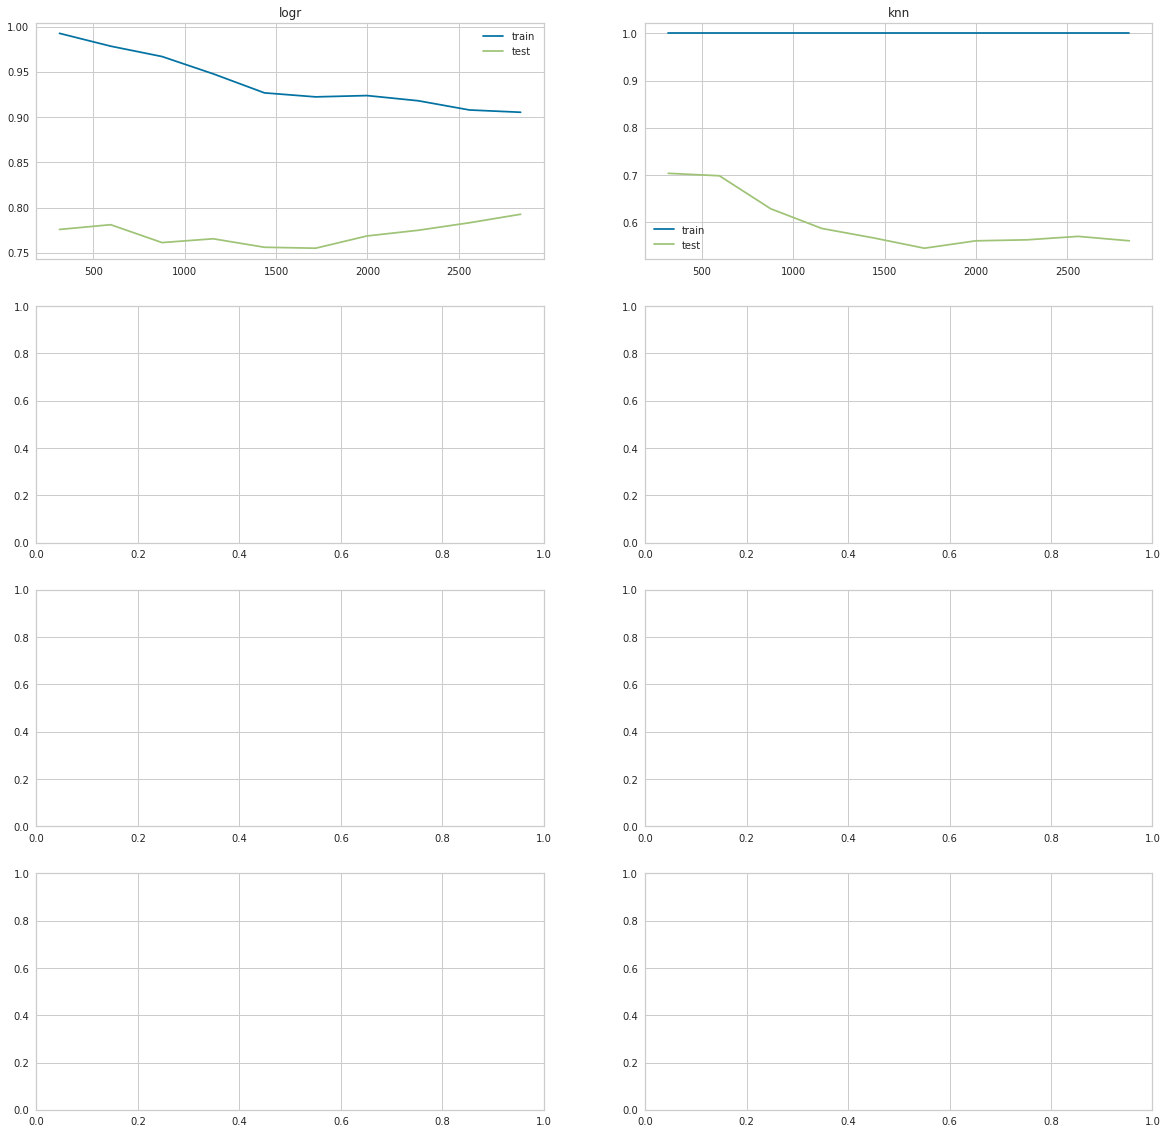

In [414]:
X = get_data('details')['X']
y = get_data('details')['y']

fig, ax = plt.subplots(4, 2, figsize=(20,20))
axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1],
        ax[2,0], ax[2,1], ax[3,0], ax[3,1]]

for i, m in enumerate(best_estimators.keys()):
    train_sizes, train_scores, test_scores = learning_curve(best_estimators[m],
                                                            X,
                                                            y,
                                                            train_sizes=np.linspace(0.1, 0.9, 10),
                                                            cv=3,
                                                            scoring='recall',
                                                            n_jobs=-1)
    
    sns.lineplot(train_sizes, train_scores.mean(axis=1), markers=True, ax=axes[i]).set_title(m)
    sns.lineplot(train_sizes, test_scores.mean(axis=1), markers=True, ax=axes[i])
    axes[i].legend(['train', 'test']);

## Precision-Recall Curves

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(20,20))
axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1],
        ax[2,0], ax[2,1], ax[3,0], ax[3,1]]

for i, m in enumerate(best_estimators.keys()):
    train_sizes, train_scores, test_scores = learning_curve(best_estimators[m],
                                                            X,
                                                            y,
                                                            train_sizes=np.linspace(0.1, 0.9, 20),
                                                            cv=3,
                                                            scoring='recall',
                                                            n_jobs=-1)
    
    sns.lineplot(train_sizes, train_scores.mean(axis=1), markers=True, ax=axes[i]).set_title(m)
    sns.lineplot(train_sizes, test_scores.mean(axis=1), markers=True, ax=axes[i])
    axes[i].legend(['train', 'test']);

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 305 out of 305 | elapsed:    0.1s finished


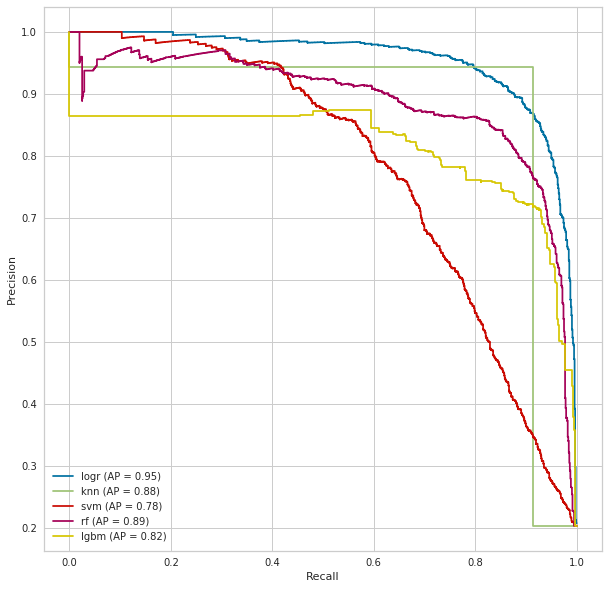

In [413]:
fig, ax = plt.subplots(figsize=(10,10))
for m in best_estimators.keys():
    plot_precision_recall_curve(best_estimators[m], X, y, name=m, ax=ax)